# Tutorial: Free-form flows

Free-form flows are a general purpose generative model that learn to sample from a probability distribution $p(x)$ given by data $x_i$.

## Free-form flow fundamentals

Just like autoencoders, free-form flows learn a pair of encoder $z = f_\theta(x)$ and decoder $x' = g_\phi(z)$ functions such that $x' \approx x$. In the basic scenario, the dimensions of $z$ and $x$ are equal.

The idea is that the latent codes $z = f_\theta(x)$ obtained via the encoder are distributed like some known simple distribution $p(z)$ like a standard normal $\mathcal N(0, I)$. New samples like the data can be obtained pushing latent noise $z \sim p(z)$ throught the deocder.

In [1]:
import torch
import numpy as np
from tqdm.auto import trange

import matplotlib.pyplot as plt

import fff.other_losses.exact_nll

In [2]:
data_set_name = "GMM-8"


def make_batch(n_samples):
    if data_set_name == "2moons":
        from sklearn.datasets import make_moons
        return torch.from_numpy(make_moons(n_samples, noise=0.1)[0]).float()
    elif data_set_name == "GMM-8":
        cluster_ids = np.random.randint(0, 8, size=n_samples)
        angles = cluster_ids / 8 * 2 * np.pi
        means = np.stack([np.cos(angles), np.sin(angles)], axis=1) * 2.0
        samples = means + np.random.randn(n_samples, 2) * 0.1
        return torch.from_numpy(samples).float()
    else:
        raise ValueError(f"Invalid data set name {data_set_name}")

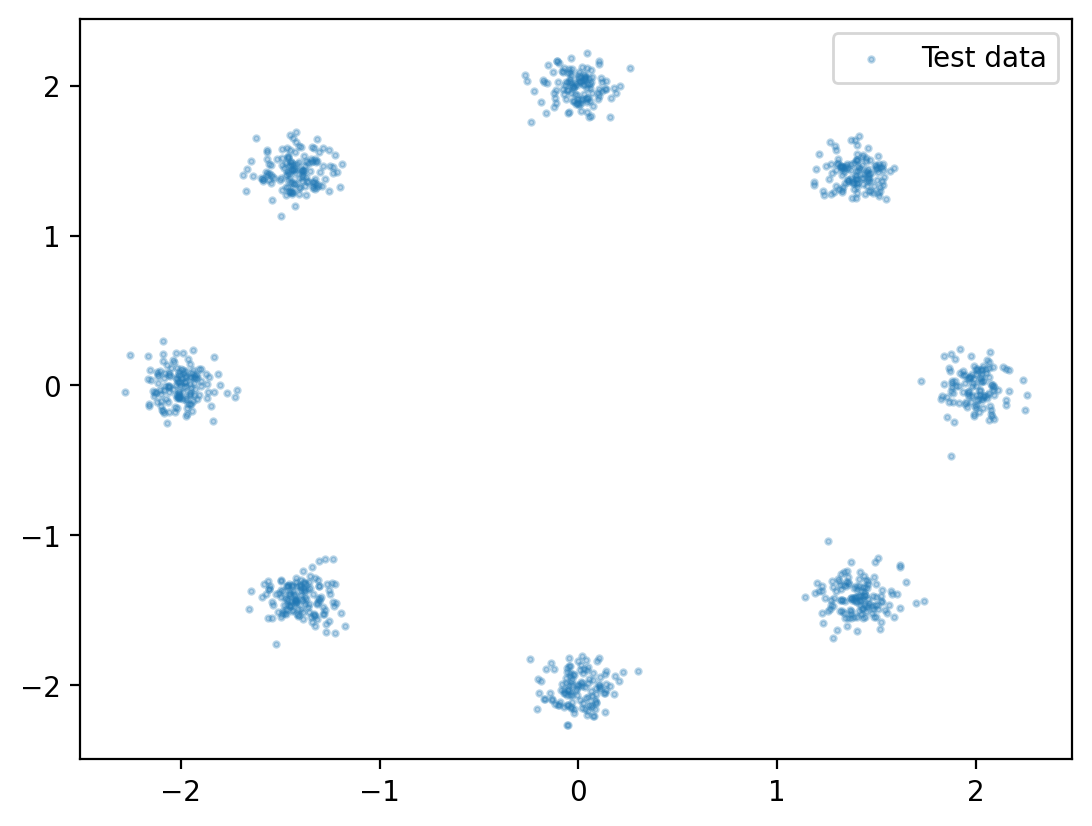

In [3]:
plot_kwargs = dict(
    s=4,
    alpha=.3
)

test_batch = make_batch(1000)
plt.scatter(*test_batch.T, **plot_kwargs, label="Test data")
plt.legend()

In [4]:
dim = 2
latent_dim = dim  # The code below also works for latent_dim < dim
depth = 8
hidden_dim = 320
non_linearity = "SiLU"
skip_connection = True

lr = 0.0004
gradient_clip = 1
n_steps = 100000
beta = 150
batch_size = 256

device = "cpu"

if device == "cpu":
    # This is usually faster
    torch.set_num_threads(1)


class SkipConnection(torch.nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner

    def forward(self, x, *args, **kwargs):
        return x + self.inner(x, *args, **kwargs)


def build_mlp(in_dim, out_dim, hidden_dim, depth, non_linearity_name, skip_connection: bool):
    non_linearity_cls = getattr(torch.nn, non_linearity_name)

    layers = [torch.nn.Linear(in_dim, hidden_dim), non_linearity_cls()]
    for _ in range(depth - 1):
        layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        layers.append(non_linearity_cls())
    layers.append(torch.nn.Linear(hidden_dim, out_dim))

    model = torch.nn.Sequential(*layers)
    if skip_connection:
        return SkipConnection(model)
    return model


# Do not use ReLU below, makes training unstable
encoder = build_mlp(dim, latent_dim, hidden_dim, depth, non_linearity, skip_connection).to(device)
decoder = build_mlp(latent_dim, dim, hidden_dim, depth, non_linearity, skip_connection).to(device)

latent = torch.distributions.Independent(
    torch.distributions.Normal(
        loc=torch.zeros(latent_dim, device=device),
        scale=torch.ones(latent_dim, device=device),
    ),
    1
)

parameters = [*encoder.parameters(), *decoder.parameters()]
optim = torch.optim.Adam(parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=n_steps
)

loss_history = []

In [5]:
test_batch = test_batch.to(device)

with trange(scheduler.last_epoch, n_steps) as pbar:
    for step in pbar:
        optim.zero_grad()
        x = make_batch(batch_size).to(device)
        surrogate = fff.loss.volume_change_surrogate(
            x, encoder, decoder,
        )
        loss_reconstruction = ((x - surrogate.x1) ** 2).sum(-1).mean(-1)
        loss_nll = -latent.log_prob(surrogate.z) - surrogate.surrogate
        loss = beta * loss_reconstruction + loss_nll
        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(parameters, gradient_clip)
        if any(torch.any(torch.isnan(param.grad)) for param in parameters):
            print(f"WARNING: NaN gradient in {step=}, skipping this step.")
        else:
            optim.step()
        scheduler.step()

        if step % 100 == 0:
            with torch.no_grad():
                nll_out = fff.other_losses.exact_nll.exact_nll(test_batch, encoder, decoder, latent)
                reconstruction = ((test_batch - nll_out.x1) ** 2).sum(-1).mean(-1)
                pbar.set_description(f"Reconstruction: {reconstruction:.1e}, NLL: {nll_out.nll.mean():.2f}")
                loss_history.append({
                    "reconstruction": reconstruction.item(),
                    "nll": nll_out.nll.mean().item(),
                    "lr": scheduler.get_last_lr()[0],
                })

  0%|          | 0/100000 [00:00<?, ?it/s]

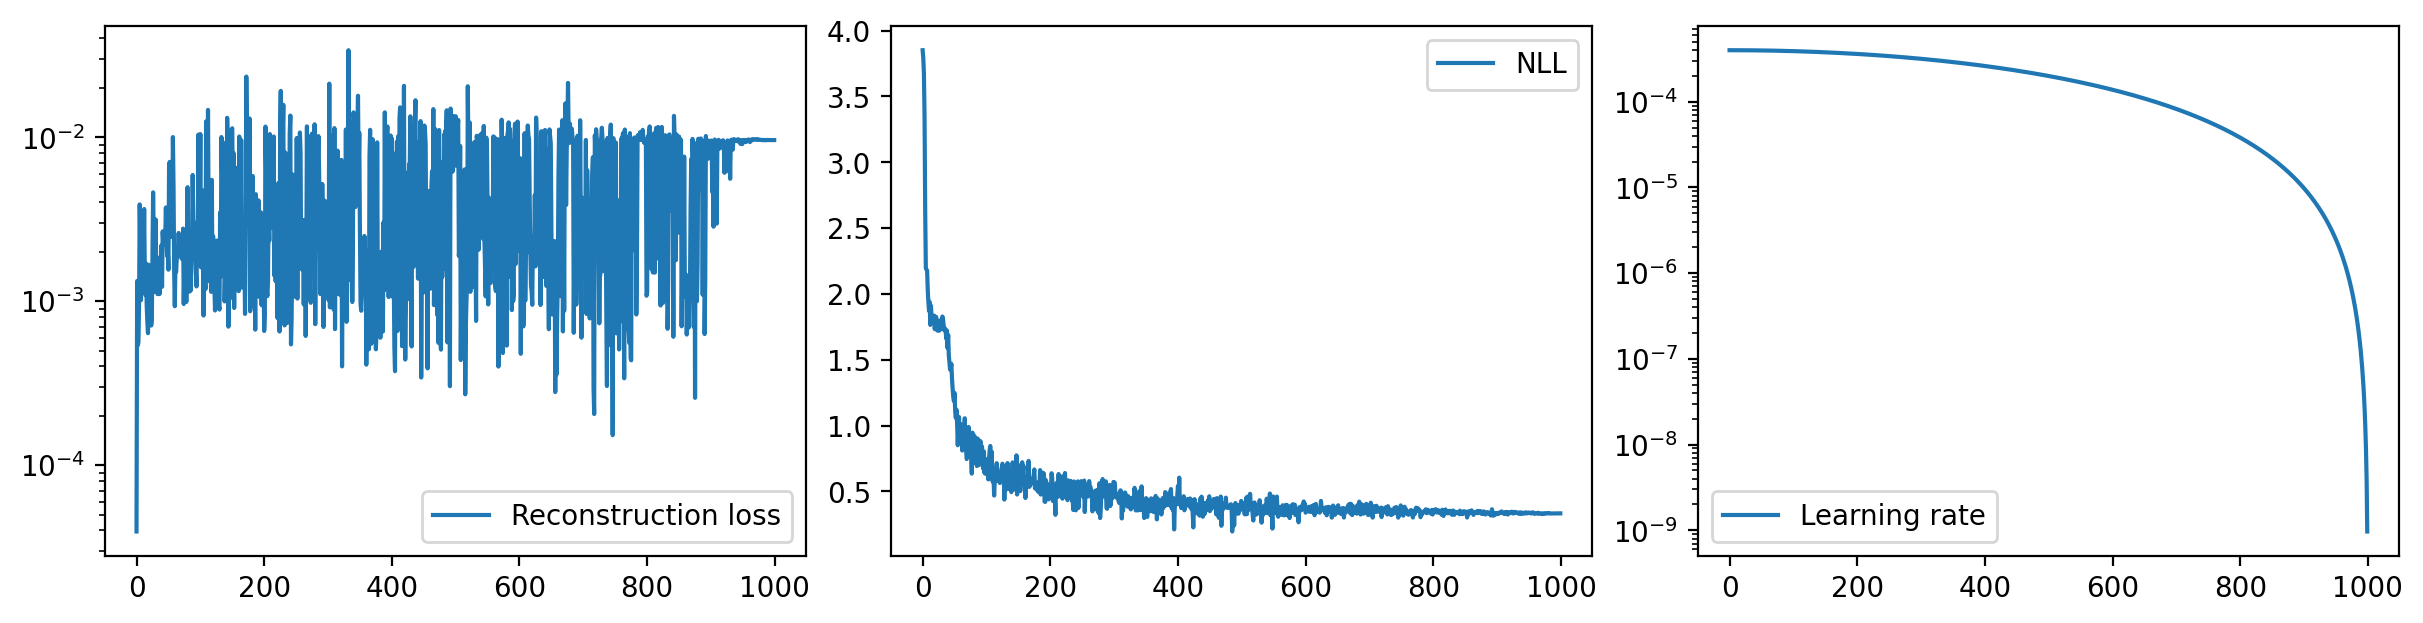

In [6]:
ax_rec, ax_nll, ax_lr = plt.subplots(1, 3, sharex=True, figsize=(12, 3),
                                     constrained_layout=True)[1]

plt.sca(ax_rec)
plt.plot([entry["reconstruction"] for entry in loss_history], label="Reconstruction loss")
plt.yscale("log")
plt.legend()

plt.sca(ax_nll)
plt.plot([entry["nll"] for entry in loss_history], label="NLL")
plt.legend()

plt.sca(ax_lr)
plt.plot([entry["lr"] for entry in loss_history], label="Learning rate")
plt.yscale("log")
plt.legend()

In [7]:
def sample(n_samples):
    z = torch.randn(n_samples, latent_dim, device=device)
    return decoder(z)

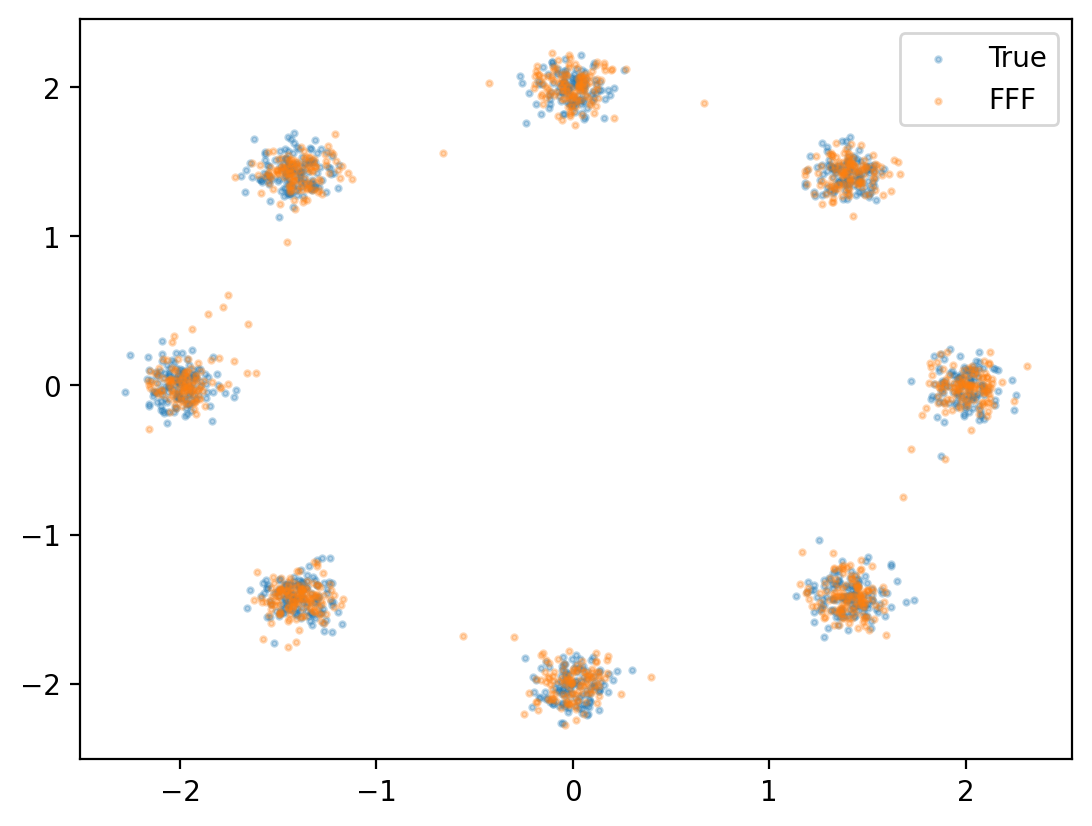

In [8]:
test_batch = test_batch.cpu()

plt.scatter(*test_batch.T, label="True", **plot_kwargs)

with torch.no_grad():
    plt.scatter(*sample(len(test_batch)).cpu().T, label="FFF", **plot_kwargs)
plt.legend()